<a href="https://colab.research.google.com/github/Nick7900/Mitochondria-detection-using-U-Net/blob/main/01_mitochondria_segmentation_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mitochondria detection using U-Net** 
The dataset available for download on this webpage represents a 5x5x5µm section taken from the CA1 hippocampus region of the brain, corresponding to a 1065x2048x1536 volume. 
The researchers have annotated mitochondria, so each image also got a corresponding mask image.

Aim:
Train a network that can detect and segment mitochondira from the dataset
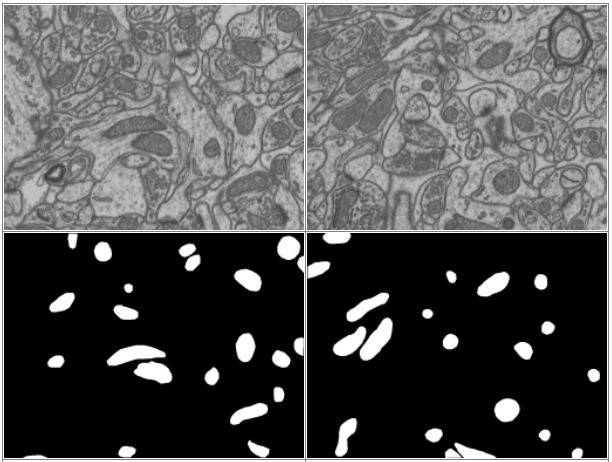


## **0.Mount to google drive**
We want to be able to save our model in our local google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## **1.U-NET Model**
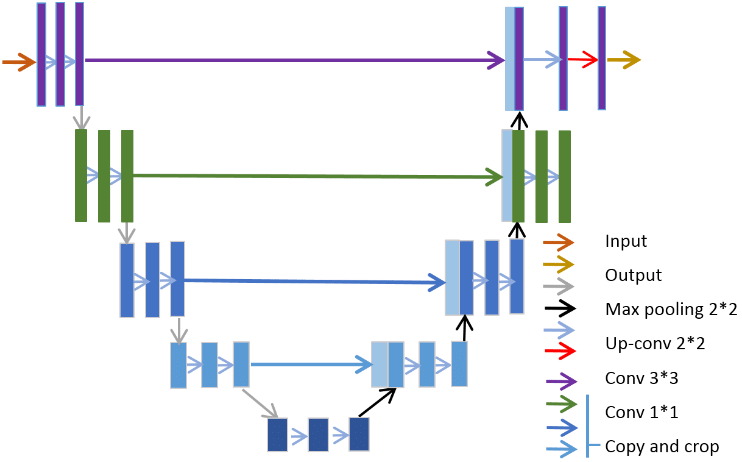

In [4]:
# U-net model 
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name="input_layer") 
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
    # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5) # Using transpose to upscale
    u6 = concatenate([u6, c4]) # Concatunate C4 with U6
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3]) # Concatunate C3 with U7
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2]) # Concatunate C2 with U8
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3) # Concatunate C1 with U9
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)



    # Build the model
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model
 

### **Download data**
Download Electron Microscopy Dataset of mitochondria: https://www.epfl.ch/labs/cvlab/data/data-em/

In [5]:
# Download data from their website
!wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training.tif
!wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training_groundtruth.tif

--2022-05-23 09:09:55--  https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training.tif
Resolving documents.epfl.ch (documents.epfl.ch)... 128.178.222.197, 2001:620:618:1de:1:80b2:dec5:1
Connecting to documents.epfl.ch (documents.epfl.ch)|128.178.222.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129919357 (124M) [application/octet-stream]
Saving to: ‘training.tif’

training.tif        100%[===================>] 123.90M   784KB/s    in 5m 9s   

2022-05-23 09:15:06 (410 KB/s) - ‘training.tif’ saved [129919357/129919357]

--2022-05-23 09:15:06--  https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training_groundtruth.tif
Resolving documents.epfl.ch (documents.epfl.ch)... 128.178.222.197, 2001:620:618:1de:1:80b2:dec5:1
Connecting to documents.epfl.ch (documents.epfl.ch)|128.178.222.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129919357 (124M) 

In [6]:
import os
# Make folders
!mkdir -p dataset/images
!mkdir -p dataset/masks
img_dir = os.path.join('dataset', 'images') # Directory
mask_dir = os.path.join('dataset', 'masks') # Directory

try:
  !mv "/content/training.tif" 'dataset/images'
  !mv "/content/training_groundtruth.tif" 'dataset/masks'
except:
  print("No files to move")

In [18]:
# Prepare dependencies
!pip install patchify
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify
import tifffile as tiff

## **2.Build Data Loading Function**
### **2.1 Define Paths to Files**

In [8]:
import random
# Get list of files within directory
img_list = os.listdir('dataset/images') 
mask_list = os.listdir('dataset/masks')
# Get a random file
img_File = random.choice(img_list) # get a random file => in this case there is only 1
mask_File = random.choice(mask_list) # get a random file => in this case there is only 1

In [9]:
# Load images
image_stack = tiff.imread(os.path.join('dataset/images', img_File))
mask_stack = tiff.imread(os.path.join('dataset/masks', mask_File))
image_stack.shape, mask_stack.shape

((165, 768, 1024), (165, 768, 1024))

### **2.2 Image patches**
Creating image patches that the model can train on

In [10]:
!mkdir -p patches/images
!mkdir -p patches/masks
image_dir = 'patches/images/'
mask_dir = 'patches/masks/'
IMG_SIZE =256

for img in range(image_stack.shape[0]):
  image = image_stack[img]
  patches_img = patchify(image, (IMG_SIZE, IMG_SIZE), step=IMG_SIZE) #Step=256 for 256 patches means no overlap

  for i in range(patches_img.shape[0]): # Row patch
    for j in range(patches_img.shape[1]): # Column patch

      single_patch_img = patches_img[i, j, :,:]
      tiff.imwrite(image_dir + 'image_' + str(img) + '_' + str(i)+str(j)+ ".tif", single_patch_img)
            
# Do the same for the masked images
for msk in range(mask_stack.shape[0]):
    mask = mask_stack[msk]
    patches_mask = patchify(mask, (IMG_SIZE, IMG_SIZE), step=IMG_SIZE)  #Step=256 for 256 patches means no overlap
    for i in range(patches_mask.shape[0]): # Row patch
        for j in range(patches_mask.shape[1]): # Column patch
            
            single_patch_mask = patches_mask[i,j,:,:]
            tiff.imwrite(mask_dir + 'mask_' + str(msk) + '_' + str(i)+str(j)+ ".tif", single_patch_mask)
            single_patch_mask = single_patch_mask / 255.
            

## **3.Sematic segmentation of mitochondria**

### **3.1 Install Dependencies**

In [11]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image # library to resize images
import numpy as np
import matplotlib.pyplot as plt

### **3.2 Resize images**
Resize all images to a specific image patch size. Just a way to ensure no images got a undisired image size.


In [12]:
IMG_SIZE = 256
image_dataset = []
mask_dataset = []

images = os.listdir(image_dir)
images.sort()
for i, image_name in enumerate(images):
  if (image_name.split('.')[1]==  'tif'):
    #print(image_dir + image_name)
    image = cv2.imread(image_dir+image_name,0) # Only looking at 1 channel/2D image
    image = Image.fromarray(image) # loading image
    image = image.resize((IMG_SIZE,IMG_SIZE))
    image_dataset.append(np.array(image)) # append the image to the dataset stack

# Do the same procedure for the mask images
masks = os.listdir(mask_dir)
masks.sort()
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(mask_dir+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((IMG_SIZE, IMG_SIZE))
        mask_dataset.append(np.array(image))


np.shape(image_dataset), np.shape(mask_dataset)

((1980, 256, 256), (1980, 256, 256))

### **3.4 Normalize images**
We are normalizing images because


In [14]:
#Normalize images
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

### **3.5 Generate Training and Test set**


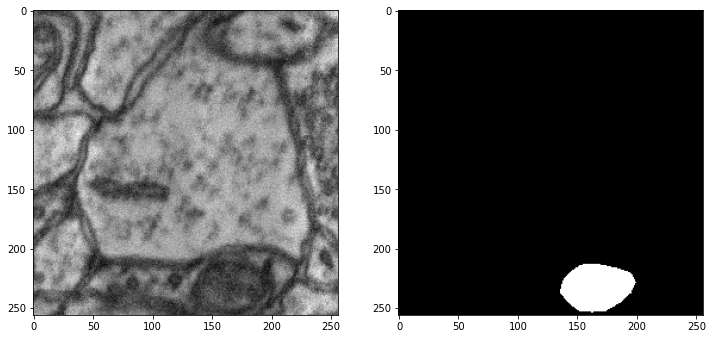

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, 
                                                    mask_dataset, 
                                                    test_size = 0.10, 
                                                    random_state = 101)

#Sanity check, view few images
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

### **3.6 Create callbacks**

In [21]:
import tensorflow as tf
# Setup checkpoint path
checkpoint_path ="model_checkpoint/mitochondria_100.hdf5"
# Create a ModelCheckpoint callback that saves the best model
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_best_only=True,
                                                         verbose = 1)

In [22]:
# Create the callback
callbacks = [tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='logs'),
             checkpoint_callback] # create a folder called logs]

### **3.7 Run the model**

In [16]:
###############################################################
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

model = simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [23]:
#If starting with pre-trained weights. 
#model.load_weights('X.hdf5')
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    shuffle=False,
                    callbacks=checkpoint_callback)

Epoch 1/100
112/112 [==============================] - ETA: 0s - loss: 0.2277 - accuracy: 0.9355
Epoch 1: val_loss improved from inf to 0.16060, saving model to model_checkpoint/mitochondria_100.hdf5
112/112 [==============================] - 38s 174ms/step - loss: 0.2277 - accuracy: 0.9355 - val_loss: 0.1606 - val_accuracy: 0.9470
Epoch 2/100
112/112 [==============================] - ETA: 0s - loss: 0.1159 - accuracy: 0.9516
Epoch 2: val_loss improved from 0.16060 to 0.09491, saving model to model_checkpoint/mitochondria_100.hdf5
112/112 [==============================] - 18s 159ms/step - loss: 0.1159 - accuracy: 0.9516 - val_loss: 0.0949 - val_accuracy: 0.9676
Epoch 3/100
112/112 [==============================] - ETA: 0s - loss: 0.0546 - accuracy: 0.9788
Epoch 3: val_loss improved from 0.09491 to 0.03807, saving model to model_checkpoint/mitochondria_100.hdf5
112/112 [==============================] - 18s 160ms/step - loss: 0.0546 - accuracy: 0.9788 - val_loss: 0.0381 - val_accurac

In [24]:
model.save('/content/drive/MyDrive/Colab Notebooks/Small_projects/UNET_models/mitochondria_100.hdf5')

In [25]:
!cp '/content/model_checkpoint/mitochondria_100.hdf5' '/content/drive/MyDrive/Colab Notebooks/Small_projects/UNET_models/'

### **3.8 Evaluate model**

7/7 [==============================] - 2s 78ms/step - loss: 0.0127 - accuracy: 0.9959
Accuracy =  99.59229230880737 %


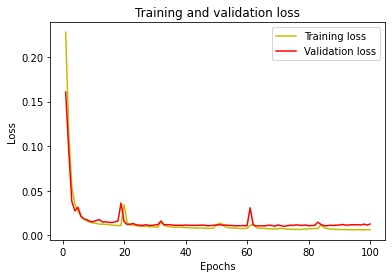

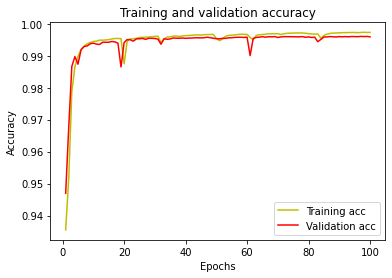

In [26]:
	# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")


#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### **IoC-score (Intersect over Union)**
IoU is quite intuitive to interpret. A score of 1 means that the predicted bounding box precisely matches the ground truth bounding box. A score of 0 means that the predicted and true bounding box do not overlap at all.

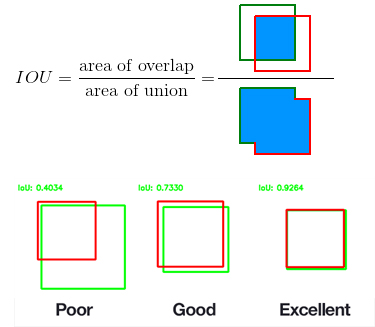

In [27]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

#http://ronny.rest/tutorials/module/localization_001/iou/#:~:text=Interpreting%20IoU%20scores,do%20not%20overlap%20at%20all.
intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU score is: ", iou_score)

IoU score is:  0.9259860827814291


### **3.10 Visualize output**

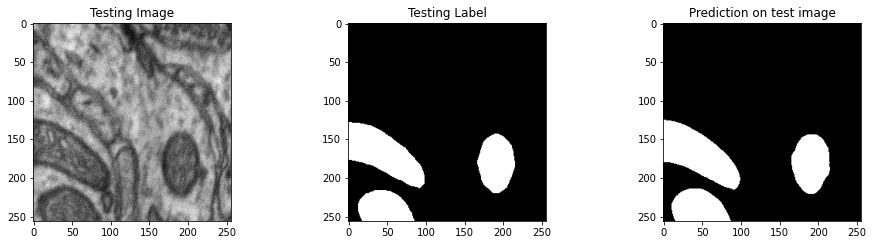

In [34]:
#Predict on a few images
# Double check if the saved model is working
loaded_saved_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Small_projects/UNET_models/mitochondria_100.hdf5')
model = loaded_saved_model

# Choose a random image to visualize on
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)

#Predict and threshold for values above 0.5 probability
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

# Plot the figures
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.show()